In [1]:
import sqlite3
import healpy as hp
from astropy import units as u
from lenstools import ConvergenceMap
import numpy as np
import io
from matplotlib import pyplot as plt
from multiprocessing import Pool, cpu_count
import argparse 

from src.utils.database_query import query_fits_paths

In [5]:
db_path = '/lustre/work/akira.tokiwa/Projects/LensingSSC/results/kappa_data.db'

In [2]:
def query_data(db_path, query):
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute(query)
    data = c.fetchall()
    conn.close()
    return data

def gen_query(config_sim, zs, sl=0, survey="noiseless"):
    query = 'SELECT * FROM lensing_data WHERE '
    query += f'config_sim="{config_sim}" AND zs={zs} AND survey="{survey}" AND sl={sl}'
    return query    

In [6]:
results = []
for config_sim in ['tiled', 'bigbox']:
        query = gen_query(config_sim, 1.0, sl=10)
        data = query_data(db_path, query)
        results.append(data)

In [7]:
def blob2np(blob):
    return np.load(io.BytesIO(blob))

In [24]:

datas = []
bins = []
for i in range(len(results)):
    data = []

    for result in results[i]:
        id, config_sim, zs, sl, survey, patch_id, lmin, lmax, ell, cl, bispec_equil, bispec_fold, nu, pdf, peak_counts, minima_counts = result
        ell = blob2np(ell)
        cl = blob2np(cl) 
        bispec_equil = blob2np(bispec_equil)
        bispec_fold = blob2np(bispec_fold)
        nu = blob2np(nu)
        pdf = blob2np(pdf)
        peak_counts = blob2np(peak_counts)
        minima_counts = blob2np(minima_counts)

        concats = np.hstack([cl, bispec_equil, bispec_fold, pdf, peak_counts, minima_counts])

        data.append(concats)

    bin = np.hstack([ell, ell, ell, nu, nu, nu])
    bins.append(bin)
    
    datas.append(np.array(data)) 

In [25]:
cov_bigbox = np.cov(datas[1], rowvar=False)
diag_bigbox = np.diag(cov_bigbox)
corr_bigbox = cov_bigbox / np.sqrt(np.outer(diag_bigbox, diag_bigbox))
corr_bigbox = np.nan_to_num(corr_bigbox)

cov_tiled = np.cov(datas[0], rowvar=False)
diag_tiled = np.diag(cov_tiled)
corr_tiled = cov_tiled / np.sqrt(np.outer(diag_tiled, diag_tiled))
corr_tiled = np.nan_to_num(corr_tiled)

/var/tmp/pbs.269384.idark/ipykernel_81060/2850383759.py:3: RuntimeWarning: invalid value encountered in true_divide
  corr_bigbox = cov_bigbox / np.sqrt(np.outer(diag_bigbox, diag_bigbox))
/var/tmp/pbs.269384.idark/ipykernel_81060/2850383759.py:8: RuntimeWarning: invalid value encountered in true_divide
  corr_tiled = cov_tiled / np.sqrt(np.outer(diag_tiled, diag_tiled))


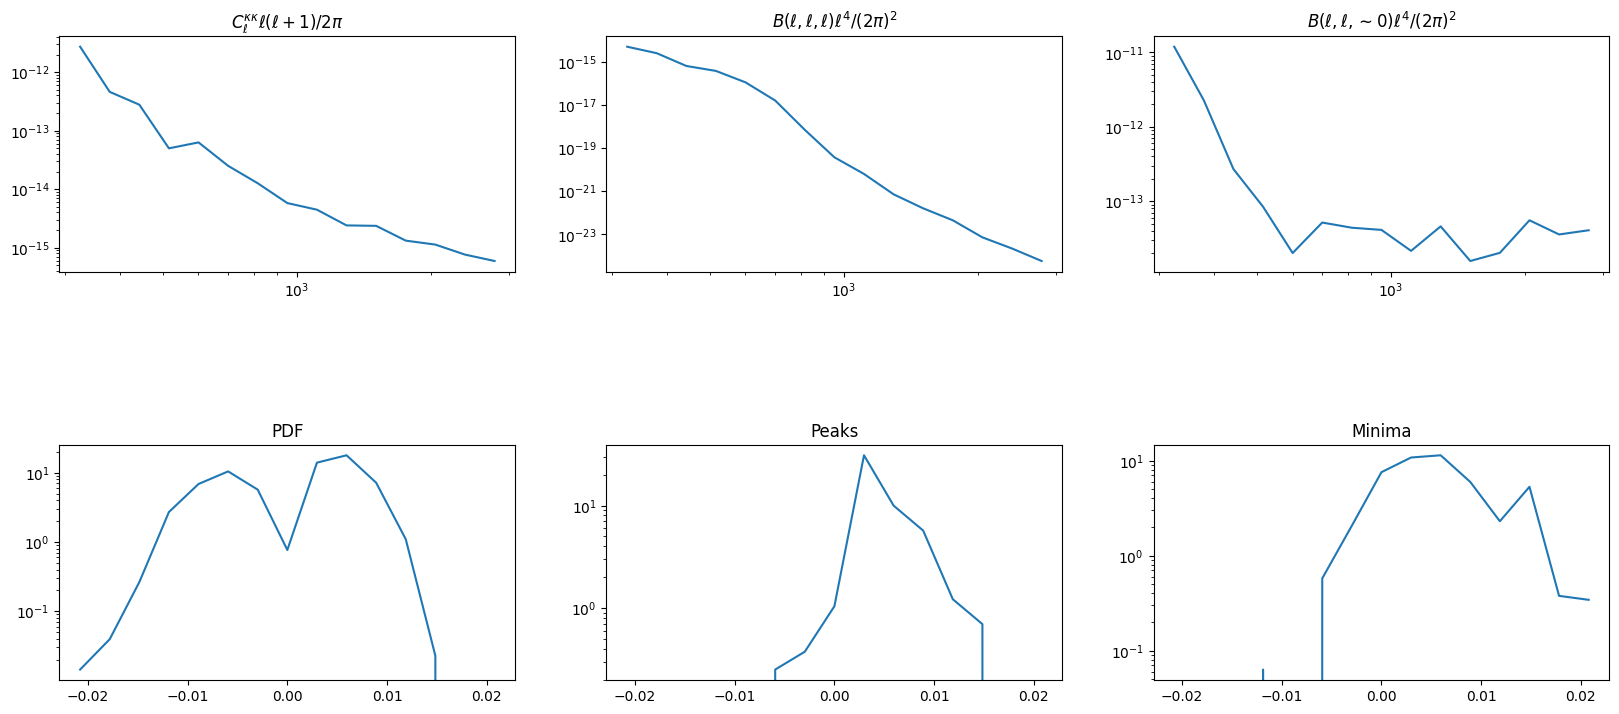

In [36]:

labels = [r'$C^{\kappa\kappa}_{\ell} \ell (\ell+1) / 2\pi$', 
          r'$B(\ell, \ell, \ell)  \ell^4 / (2\pi)^2 $', 
          r'$B(\ell, \ell, \sim0)  \ell^4 / (2\pi)^2$',
          "PDF",
          "Peaks",
          "Minima"
          ]

# Create the figure and GridSpec layout
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(4, 3, height_ratios=[3, 1, 3, 1], hspace=0.3)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)] + [fig.add_subplot(gs[2, i]) for i in range(3)]

for i, label in enumerate(labels):
    ax = axes[i]
    im = ax.plot(bins[0][i*15:i*15+15], diag_tiled[i*15:i*15+15], label="Tiled")
    ax.set_title(label)
    ax.set_yscale('log')
    ax.set_xscale('log') if i < 3 else None

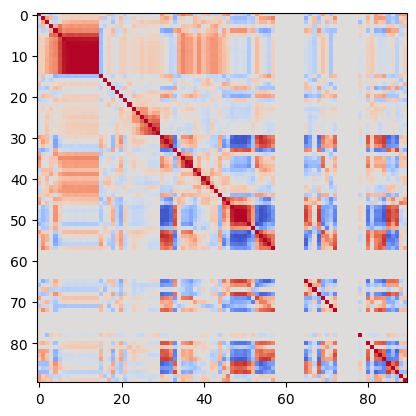

In [18]:
plt.imshow(corr_tiled, cmap='coolwarm', vmin=-1, vmax=1)

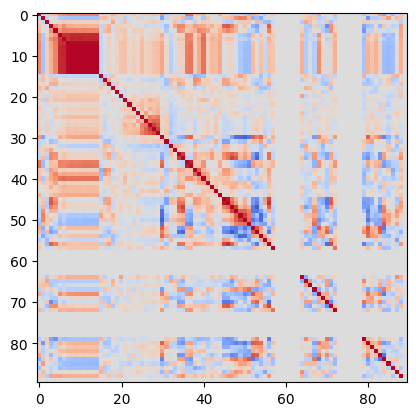

In [19]:
plt.imshow(corr_bigbox, cmap='coolwarm', vmin=-1, vmax=1)

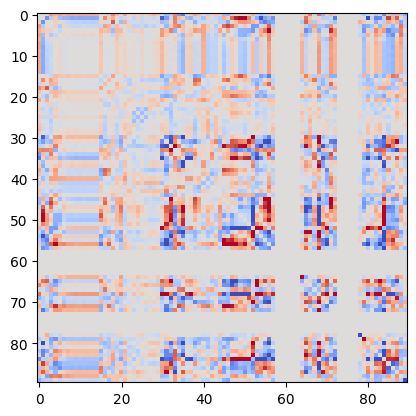

In [20]:
plt.imshow(corr_bigbox - corr_tiled, cmap='coolwarm', vmin=-1, vmax=1)

/var/tmp/pbs.269384.idark/ipykernel_81060/1247963678.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


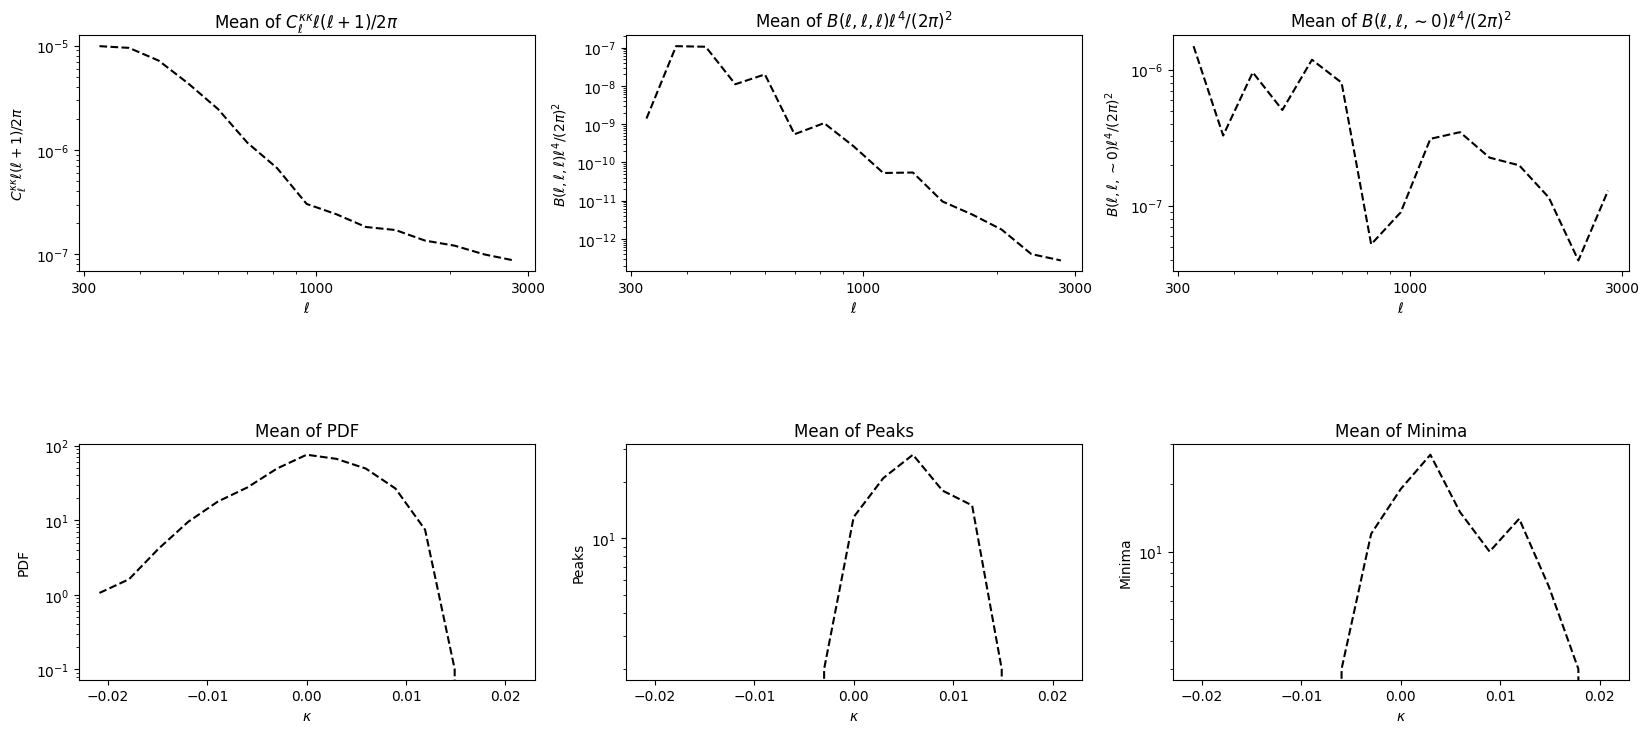

In [23]:
from matplotlib.gridspec import GridSpec

labels = [r'$C^{\kappa\kappa}_{\ell} \ell (\ell+1) / 2\pi$', 
          r'$B(\ell, \ell, \ell)  \ell^4 / (2\pi)^2 $', 
          r'$B(\ell, \ell, \sim0)  \ell^4 / (2\pi)^2$',
          "PDF",
          "Peaks",
          "Minima"
          ]

# Define line styles
line_styles = {"tiled": "--", "bigbox": "-"}

binsize = 14

# Create the figure and GridSpec layout
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(4, 3, height_ratios=[3, 1, 3, 1], hspace=0.3)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)] + [fig.add_subplot(gs[2, i]) for i in range(3)]

elldata = [cl, bispec_equil, bispec_fold]
for i, ax, data, label in zip(range(len(elldata)), axes[:3], elldata, labels[:3]):
    ax.plot(ell, data, label=f"zs=1.0", color='black', linestyle=line_styles["tiled"])
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(label)
    ax.set_ylabel(label)
    ax.set_xlabel(r"$\ell$")
    ax.set_xticks([300, 1000, 3000])

pdfdata = [pdf, peak_counts, minima_counts]
for i, ax, data, label in zip(range(len(pdfdata)), axes[3:], pdfdata, labels[3:]):
    ax.plot(nu, data, label=f"zs=1.0", color='black', linestyle=line_styles["tiled"])
    ax.set_title(label)
    ax.set_ylabel(label)
    ax.set_xlabel(r"$\kappa$")

# Set the axis labels
for i, ax, label in zip(range(len(axes)), axes, labels):
    ax.set_title(f"Mean of {label}")
    ax.set_ylabel(label)
    ax.set_xticklabels([])
    ax.set_yscale("log")
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.get_xaxis().set_minor_formatter(plt.NullFormatter())

plt.tight_layout()
plt.show()